In [2]:
# Core libs
import os, math, cv2, numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks


In [3]:
def show(img, title=None, cmap=None, size=(12,4)):
    plt.figure(figsize=size)
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or 'gray', vmin=0, vmax=255 if img.dtype==np.uint8 else None)
    else:
        plt.imshow(img)
    if title: plt.title(title)
    plt.axis('off')
    plt.show()

def overlay_lines(img_rgb, xs, color=(255,0,0), lw=2):
    """Draw vertical lines (xs iterable) on an RGB image (copy)."""
    vis = img_rgb.copy()
    for x in xs:
        x = int(round(x))
        cv2.line(vis, (x,0), (x,vis.shape[0]-1), color, lw)
    return vis


### 1) Color-aware character mask (ignore black lines)

- Idea: characters are colored; background is white; noise lines are thin & near-black.
So in HSV:

- treat near-black as line/noise → remove

- treat low-sat/high-val (white) as background → remove

- remaining pixels are colored characters → keep

In [4]:
def rgb_to_hsv(img_rgb):
    return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

def make_char_mask(img_rgb,
                   black_gray_th=10,   # <= this is "near black"
                   white_gray_th=245,  # >= this is "near white"
                   open_ksz=3,
                   close_ksz=3):
    """
    Build a binary mask where white = candidate characters, using *extreme*
    grayscale thresholds:
      - near-black (0..black_gray_th)  -> treated as noise lines
      - near-white (white_gray_th..255)-> treated as background
      - everything in between          -> kept as "ink"
    Assumes:
      - background is very close to white
      - noise lines are very close to black
      - characters are coloured and not extremely dark/bright.
    """
    # Convert to grayscale [0..255]
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    # near black: 0..10 (by default)
    near_black = (gray <= black_gray_th).astype(np.uint8)

    # near white: 245..255 (by default)
    near_white = (gray >= white_gray_th).astype(np.uint8)

    # character ink = everything that is not extreme black or extreme white
    char = (1 - near_black) & (1 - near_white)   # 1 = keep, 0 = discard

    mask = (char * 255).astype(np.uint8)

    # Morphological cleanup: remove tiny bits / fill tiny gaps
    k_open  = cv2.getStructuringElement(cv2.MORPH_RECT, (open_ksz, open_ksz))
    k_close = cv2.getStructuringElement(cv2.MORPH_RECT, (close_ksz, close_ksz))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  k_open)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k_close)

    return mask



In [5]:
def ink_boolean_map(img_rgb,
                    black_gray_th=10,
                    white_gray_th=245):
    """
    Returns a boolean array ink[y,x] that is True iff the pixel is not extreme
    black and not extreme white.
    """
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    # ignore near-black and near-white
    ink = (gray > black_gray_th) & (gray < white_gray_th)
    return ink


In [6]:
def tiles_to_ink_masks(tiles,
                       black_gray_th: int = 10,
                       white_gray_th: int = 245):
    """
    Convert a list of RGB tiles to binary ink masks using the same logic as
    ink_boolean_map:

        gray = cv2.cvtColor(tile, GRAY)
        ink  = (gray > black_gray_th) & (gray < white_gray_th)

    Returns a list of 2D uint8 arrays with values 0 or 255.
    """
    ink_tiles = []
    for tile in tiles:
        # tile is 64×64×3 RGB
        gray = cv2.cvtColor(tile, cv2.COLOR_RGB2GRAY)

        is_black = gray <= black_gray_th
        is_white = gray >= white_gray_th
        ink = (~is_black) & (~is_white)

        bin_tile = (ink.astype(np.uint8) * 255)  # 0 or 255
        ink_tiles.append(bin_tile)

    return ink_tiles


### 2) Robust vertical crop via ink projection

We find a band [xL, xR] that tightly contains characters by projecting mask columns and smoothing.
We also do hysteresis: require a small run of consecutive columns above threshold to start/stop.

In [7]:
def vertical_crop_from_mask(mask,
                            smooth_sigma=3,
                            bin_th=5,            # min ink pixels to consider "active" column
                            min_run=5):          # hysteresis run length
    """
    Returns xL, xR (inclusive bounds) based on column ink counts.
    """
    col_count = mask.sum(axis=0) // 255
    col_smooth = gaussian_filter1d(col_count.astype(np.float32), sigma=smooth_sigma)
    active = (col_smooth >= bin_th).astype(np.uint8)

    # hysteresis: expand active runs >= min_run
    starts, ends = [], []
    run = 0
    for i, v in enumerate(active):
        if v: run += 1
        else:
            if run >= min_run:
                starts.append(i-run)
                ends.append(i-1)
            run = 0
    if run >= min_run:
        starts.append(len(active)-run)
        ends.append(len(active)-1)

    if not starts:
        # fallback: whole width
        return 0, mask.shape[1]-1, col_count, col_smooth

    xL = min(starts)
    xR = max(ends)
    return int(xL), int(xR), col_count, col_smooth


In [8]:
from scipy.ndimage import gaussian_filter1d
# def vertical_crop_from_ink(ink_bool, min_col_ink=1, pad=3):
#     H, W = ink_bool.shape
#     col_count = ink_bool.sum(axis=0)
#     xs = np.where(col_count >= min_col_ink)[0]

#     if xs.size == 0:
#         return 0, W - 1, col_count, col_count.astype(float)

#     xL = max(0, xs[0] - pad)
#     xR = min(W - 1, xs[-1] + pad)
#     col_smooth = col_count.astype(float)
#     return xL, xR, col_count, col_smooth

def vertical_crop_from_ink(ink_bool,
                              min_col_ink=1,
                              pad=3):
    """
    Simple, robust vertical crop:
      - col_count = #ink pixels per column
      - active columns = col_count >= min_col_ink
      - find longest contiguous run of active columns
      - xL/xR = start/end of that run, padded by 'pad' pixels

    This avoids missing slanted/thin starts of characters.
    """
    H, W = ink_bool.shape
    col_count = ink_bool.sum(axis=0)

    # columns that contain some ink
    active = col_count >= min_col_ink

    # find contiguous runs of active columns
    starts, ends, run = [], [], 0
    for i, v in enumerate(active):
        if v:
            run += 1
        else:
            if run > 0:
                starts.append(i - run)
                ends.append(i - 1)
                run = 0
    if run > 0:
        starts.append(W - run)
        ends.append(W - 1)

    if not starts:
        # no ink at all; fall back to whole width
        return 0, W - 1, col_count, col_count.astype(float)

    # Instead of longest run, use the first/last active columns over ALL runs.
    # This keeps thin/slanted beginnings of the first character.
    xL = min(starts)
    xR = max(ends)

    # pad a bit on both sides
    xL = max(0, xL - pad)
    xR = min(W - 1, xR + pad)

    # for plotting we can treat "smoothed" as just col_count here
    col_smooth = col_count.astype(float)

    return xL, xR, col_count, col_smooth

### 3) Centers by ink projection (primary) + color-clustering fallback (optional)

Primary: find num_chars peaks on the column projection inside [xL,xR].

Fallback (overlaps): if peaks < num_chars, cluster the colored pixels in HSV space (H & S) into k=num_chars, then compute each cluster’s column mean as a center.

In [9]:
def centers_from_projection(mask, xL, xR, num_chars,
                            smooth_sigma=2, peak_prom=5, min_dist_frac=0.6):
    """
    Find centers via ink projection peaks inside [xL, xR] (inclusive).
    """
    # inclusive slice: xR+1
    band = mask[:, xL:xR+1]
    proj = (band.sum(axis=0) // 255).astype(np.float32)
    proj_s = gaussian_filter1d(proj, sigma=smooth_sigma)

    # distance ~ fraction of expected char width
    band_w = max(1, xR - xL + 1)
    min_dist = max(1, int((band_w/num_chars) * min_dist_frac))
    peaks, _ = find_peaks(proj_s, prominence=peak_prom, distance=min_dist)

    centers = (peaks + xL).astype(np.int32)  # map back to full columns
    return centers, proj, proj_s


def centers_from_color_clusters(img_rgb, mask, xL, xR, num_chars):
    """
    Cluster colored pixels (inside [xL, xR]) by hue+sat (k=num_chars).
    Returns centers as column means (x) per cluster.
    Uses cv2.kmeans to avoid sklearn dependency.
    """
    # inclusive band slice for both HSV and mask
    hsv_full = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    hsv_band = hsv_full[:, xL:xR+1, :]          # (H, bandW, 3)
    band_mask = (mask[:, xL:xR+1] > 0)          # (H, bandW)

    ys, xs = np.where(band_mask)
    if xs.size < num_chars:                      # not enough pixels to cluster
        return np.array([], dtype=np.int32)

    # features: H & S normalized (ignore V)
    H = hsv_band[:, :, 0][band_mask].astype(np.float32) / 180.0
    S = hsv_band[:, :, 1][band_mask].astype(np.float32) / 255.0
    feats = np.stack([H, S], axis=1)

    # k-means on color features
    K = num_chars
    # If too few pixels, reduce K gracefully
    if feats.shape[0] < K:
        K = max(1, min(num_chars, feats.shape[0]))

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 60, 1e-3)
    compactness, labels, centers = cv2.kmeans(feats, K=K, bestLabels=None,
                                              criteria=criteria, attempts=5,
                                              flags=cv2.KMEANS_PP_CENTERS)
    labels = labels.ravel()

    centers_x = []
    for k in range(K):
        # xs are 0..bandW-1; map back to full image columns with xL offset
        xs_k = xs[labels == k] + xL
        if xs_k.size > 0:
            centers_x.append(np.mean(xs_k))

    if not centers_x:
        return np.array([], dtype=np.int32)

    centers_x = np.array(sorted(centers_x)).astype(np.int32)
    return centers_x

In [10]:
def centers_from_ink_projection(ink_bool, xL, xR, num_chars,
                                smooth_sigma=2,
                                peak_prom=5,
                                min_dist_frac=0.6):
    """
    Find character centers via column ink projection inside [xL, xR].
    """
    band = ink_bool[:, xL:xR+1]
    proj = band.sum(axis=0).astype(np.float32)
    proj_s = gaussian_filter1d(proj, sigma=smooth_sigma)

    band_w = max(1, xR - xL + 1)
    min_dist = max(1, int((band_w/num_chars) * min_dist_frac))
    peaks, _ = find_peaks(proj_s, prominence=peak_prom, distance=min_dist)

    centers = (peaks + xL).astype(np.int32)
    return centers, proj, proj_s

def centers_from_color_clusters_nomask(img_rgb, ink_bool, xL, xR, num_chars):
    """
    Cluster colored ink pixels in [xL, xR] by (H,S) to get one center per
    color-ish group. Uses ink_bool (no separate mask).
    """
    hsv_full = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    hsv_band = hsv_full[:, xL:xR+1, :]
    band_ink = ink_bool[:, xL:xR+1]

    ys, xs = np.where(band_ink)
    if xs.size < num_chars:
        return np.array([], dtype=np.int32)

    H = hsv_band[:, :, 0][band_ink].astype(np.float32) / 180.0
    S = hsv_band[:, :, 1][band_ink].astype(np.float32) / 255.0
    feats = np.stack([H, S], axis=1)

    K = min(num_chars, feats.shape[0])
    if K <= 0:
        return np.array([], dtype=np.int32)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 60, 1e-3)
    compactness, labels, centers = cv2.kmeans(
        feats, K=K, bestLabels=None,
        criteria=criteria, attempts=5,
        flags=cv2.KMEANS_PP_CENTERS
    )
    labels = labels.ravel()

    centers_x = []
    for k in range(K):
        xs_k = xs[labels == k] + xL
        if xs_k.size > 0:
            centers_x.append(np.mean(xs_k))
    if not centers_x:
        return np.array([], dtype=np.int32)

    return np.array(sorted(centers_x)).astype(np.int32)

In [11]:
def centers_from_kmeans_x(ink_bool, xL, xR, num_chars):
    """
    Compute character centers by clustering ink pixel x-positions inside [xL,xR]
    into num_chars clusters (1D k-means).

    Returns: sorted 1D np.array of center x-coordinates (int).
    """
    band = ink_bool[:, xL:xR+1]
    ys, xs = np.where(band)
    if xs.size < num_chars:
        # not enough ink pixels, give up
        return np.array([], dtype=np.int32)

    xs_full = xs + xL      # map back to full-image x coords
    data = xs_full.astype(np.float32).reshape(-1, 1)

    K = min(num_chars, data.shape[0])
    if K <= 0:
        return np.array([], dtype=np.int32)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 60, 1e-3)
    _compact, labels, centers = cv2.kmeans(
        data, K=K, bestLabels=None,
        criteria=criteria, attempts=5,
        flags=cv2.KMEANS_PP_CENTERS
    )

    centers = np.sort(centers.ravel()).astype(np.int32)
    return centers


In [12]:
def centers_from_valleys(ink_bool, xL, xR, num_chars,
                         smooth_sigma=2,
                         valley_prom=3.0):
    """
    Use valleys (local minima) in the ink projection inside [xL, xR]
    to define character boundaries, then take centers as midpoints.

    Returns:
        centers: np.array of length <= num_chars with x-coordinates (int)
        proj:    raw band projection
        proj_s:  smoothed band projection
        valley_x: absolute x-positions of selected valleys (for debug)
    """
    band = ink_bool[:, xL:xR+1]
    proj = band.sum(axis=0).astype(np.float32)
    proj_s = gaussian_filter1d(proj, sigma=smooth_sigma)

    # Invert projection: peaks of "inv" = valleys of proj_s
    inv = np.max(proj_s) - proj_s
    band_w = max(1, xR - xL + 1)
    approx_char_width = band_w / max(1, num_chars)

    # distance ~ half expected char width -> avoids multiple valleys within one gap
    min_dist = max(1, int(approx_char_width * 0.5))

    peaks, _props = find_peaks(inv, prominence=valley_prom, distance=min_dist)
    # peaks are valley positions in band coordinates

    if peaks.size == 0:
        # no clear valleys found
        return np.array([]), proj, proj_s, np.array([])

    # We want at most (num_chars-1) internal valleys.
    # Choose the deepest ones = smallest proj_s at that position.
    if peaks.size > num_chars - 1:
        order = np.argsort(proj_s[peaks])  # ascending -> deeper valleys first
        peaks = np.sort(peaks[order[:num_chars-1]])
    else:
        peaks = np.sort(peaks)

    valley_x = peaks + xL   # convert to full-image coordinates

    # Boundaries = [xL, valley1, valley2, ..., xR]
    bounds = np.concatenate(([xL], valley_x, [xR]))
    centers = ((bounds[:-1] + bounds[1:]) / 2.0).astype(np.int32)

    return centers, proj, proj_s, valley_x


### 4) Split into segments around centers

We build cut boundaries as midpoints between adjacent centers, pad to the crop band, and extract.
Each segment is resized to 64×64 with preserved aspect ratio (letterboxed).

In [13]:
def segments_from_centers(img_rgb, ink_bool, xL, xR, centers, target_size=64):
    centers = np.array(sorted(centers))
    mids = [ (a+b)/2 for a,b in zip(centers[:-1], centers[1:]) ]
    bounds = [xL] + mids + [xR]
    bounds = [int(round(b)) for b in bounds]

    tiles = []
    for i in range(len(centers)):
        x0, x1 = bounds[i], bounds[i+1]
        x0 = max(xL, min(x0, xR))
        x1 = max(xL, min(x1, xR))
        if x1 <= x0:
            x1 = min(x0 + 1, xR)

        # use ink_bool to decide vertical extent (ignores black line)
        sub_ink = ink_bool[:, x0:x1+1]
        ys, xs = np.where(sub_ink)
        if ys.size > 0:
            y0, y1 = ys.min(), ys.max()+1
            crop = img_rgb[y0:y1, x0:x1+1]
        else:
            # fallback: no ink detected, just take full height strip
            crop = img_rgb[:, x0:x1+1]

        # letterbox to 64×64
        h, w = crop.shape[:2]
        scale = min(target_size/w, target_size/h)
        nh, nw = int(round(h*scale)), int(round(w*scale))
        resized = cv2.resize(crop, (nw, nh), interpolation=cv2.INTER_AREA)
        canvas = np.full((target_size, target_size, 3), 255, dtype=np.uint8)
        yoff = (target_size - nh)//2
        xoff = (target_size - nw)//2
        canvas[yoff:yoff+nh, xoff:xoff+nw] = resized
        tiles.append(canvas)
    return tiles


In [14]:
def segments_from_centers(img_rgb, ink_bool, xL, xR, centers, target_size=64):
    """
    Split the CAPTCHA into character tiles.

    - Uses [xL, xR] and centers from the valley / projection stage.
    - Uses ink_bool BOTH to:
        (1) decide vertical crop (y0..y1)
        (2) actually mask out non-ink pixels in the crop
          -> this removes residual noise lines from the RGB tiles.
    - Adds a bit of zoom-out so characters don't touch the tile border.
    """
    centers = np.array(sorted(centers), dtype=float)
    mids = [(a + b) / 2.0 for a, b in zip(centers[:-1], centers[1:])]
    bounds = [xL] + mids + [xR]
    bounds = [int(round(b)) for b in bounds]

    H, W = img_rgb.shape[:2]
    tiles = []

    zoom_out = 0.90  # 1.0 = fill as much as possible, <1.0 = add padding

    for i in range(len(centers)):
        x0, x1 = bounds[i], bounds[i + 1]

        # keep within [xL, xR] (inclusive)
        x0 = max(xL, min(x0, xR))
        x1 = max(xL, min(x1, xR))
        if x1 <= x0:
            x1 = min(x0 + 1, xR)

        # use ink_bool to decide vertical extent
        sub_ink_full = ink_bool[:, x0:x1 + 1]
        ys, xs = np.where(sub_ink_full)

        if ys.size > 0:
            y0, y1 = ys.min(), ys.max() + 1

            # crop both RGB and ink map (copy RGB so we can modify it)
            crop_rgb = img_rgb[y0:y1, x0:x1 + 1].copy()
            sub_ink = sub_ink_full[y0:y1, :]

            # *** KEY STEP: mask out non-ink pixels ***
            # anything that was not "ink" in the binary map becomes background (white)
            crop_rgb[~sub_ink] = 255
        else:
            # fallback: no ink detected; take whole height strip without masking
            y0, y1 = 0, H
            crop_rgb = img_rgb[:, x0:x1 + 1].copy()

        h, w = crop_rgb.shape[:2]
        if h == 0 or w == 0:
            tiles.append(np.full((target_size, target_size, 3), 255, np.uint8))
            continue

        # zoomed-out scaling
        base_scale = min(target_size / w, target_size / h)
        scale = zoom_out * base_scale
        nw = max(1, int(round(w * scale)))
        nh = max(1, int(round(h * scale)))

        resized = cv2.resize(crop_rgb, (nw, nh), interpolation=cv2.INTER_AREA)

        # center on white canvas
        canvas = np.full((target_size, target_size, 3), 255, np.uint8)
        yoff = (target_size - nh) // 2
        xoff = (target_size - nw) // 2
        canvas[yoff:yoff + nh, xoff:xoff + nw] = resized
        tiles.append(canvas)

    return tiles


### 5) Full pipeline

Build char mask ignoring black lines

Compute vertical crop

Get centers (projection → color-cluster fallback)

Split and resize to 64×64

Visualize each stage

In [15]:
def segments_from_centers_ink(ink_bool, xL, xR, centers, target_size=64):
    """
    Same splitting as segments_from_centers but operates purely on ink_bool
    and returns binary 0/255 tiles. Adds slight zoom-out padding.
    """
    centers = np.array(sorted(centers), dtype=float)
    mids = [(a + b) / 2.0 for a, b in zip(centers[:-1], centers[1:])]
    bounds = [xL] + mids + [xR]
    bounds = [int(round(b)) for b in bounds]

    H, W = ink_bool.shape
    tiles = []

    zoom_out = 0.90

    for i in range(len(centers)):
        x0, x1 = bounds[i], bounds[i + 1]
        x0 = max(xL, min(x0, xR))
        x1 = max(xL, min(x1, xR))
        if x1 <= x0:
            x1 = min(x0 + 1, xR)

        sub = ink_bool[:, x0:x1 + 1]  # binary strip
        ys, xs = np.where(sub)
        if ys.size > 0:
            y0, y1 = ys.min(), ys.max() + 1
            crop = sub[y0:y1, :]
        else:
            crop = sub

        crop_u8 = (crop.astype(np.uint8) * 255)

        h, w = crop_u8.shape
        if h == 0 or w == 0:
            tiles.append(np.zeros((target_size, target_size), np.uint8))
            continue

        base_scale = min(target_size / w, target_size / h)
        scale = zoom_out * base_scale
        nw = max(1, int(round(w * scale)))
        nh = max(1, int(round(h * scale)))

        resized = cv2.resize(crop_u8, (nw, nh), interpolation=cv2.INTER_NEAREST)

        canvas = np.zeros((target_size, target_size), np.uint8)  # black background
        yoff = (target_size - nh) // 2
        xoff = (target_size - nw) // 2
        canvas[yoff:yoff + nh, xoff:xoff + nw] = resized

        tiles.append(canvas)

    return tiles


In [16]:
def segment_captcha_color_ink(img_rgb, num_chars,
                              viz=True,
                              mask_kwargs=None,
                              proj_kwargs=None):
    H, W = img_rgb.shape[:2]
    mask = make_char_mask(img_rgb, **(mask_kwargs or {}))

    xL, xR, col_count, col_smooth = vertical_crop_from_mask(
        mask, **(proj_kwargs or {})
    )

    # centers from projection (uses inclusive [xL, xR] internally)
    centers, proj_raw, proj_s = centers_from_projection(mask, xL, xR, num_chars)

    if len(centers) < num_chars:
        centers2 = centers_from_color_clusters(img_rgb, mask, xL, xR, num_chars)
        if centers2.size:
            cand = np.unique(np.concatenate([centers, centers2])).astype(np.int32)
        else:
            cand = centers

        if cand.size >= num_chars:
            xs = cand.reshape(-1,1).astype(np.float32)
            criteria=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,60,1e-3)
            _, lbls, ctrs = cv2.kmeans(xs, K=num_chars, bestLabels=None,
                                       criteria=criteria, attempts=5,
                                       flags=cv2.KMEANS_PP_CENTERS)
            centers = np.sort(ctrs.ravel()).astype(np.int32)
        else:
            centers = np.sort(cand).astype(np.int32)

    if len(centers) < num_chars:
        spacing = (xR - xL) / num_chars
        centers = np.array([xL + (i+0.5)*spacing for i in range(num_chars)]).astype(np.int32)

    tiles = segments_from_centers(img_rgb, xL, xR, centers, target_size=64)

    if viz:
        # Show stages
        show(mask, "Character Mask (white=characters)", size=(16,3))
        edges_vis = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        show(overlay_lines(edges_vis, [xL, xR], (255,0,0), 2), "Mask with xL/xR", size=(16,2.5))

        plt.figure(figsize=(12,3))
        plt.title("Column ink count & smoothed (for vertical crop)")
        plt.plot(col_count, label="ink count")
        plt.plot(col_smooth, label="smoothed")
        plt.axvline(xL, color='r', ls='--'); plt.axvline(xR, color='r', ls='--')
        plt.legend(); plt.xlabel("column"); plt.ylabel("ink"); plt.grid(True)
        plt.show()

        band_vis = img_rgb.copy()
        band_vis[:, :xL] = (band_vis[:, :xL]*0.2).astype(np.uint8)
        band_vis[:, xR+1:] = (band_vis[:, xR+1:]*0.2).astype(np.uint8)
        show(overlay_lines(band_vis, centers, (0,255,0), 2), "Centers (green) inside band", size=(16,3))

        plt.figure(figsize=(12,3))
        plt.title("Projection in band (raw and smoothed)")
        plt.plot(proj_raw, label="raw")
        plt.plot(proj_s, label="smoothed")
        plt.legend(); plt.xlabel("band column"); plt.ylabel("ink"); plt.grid(True)
        plt.show()

        canvas = np.hstack(tiles) if len(tiles)>0 else np.zeros((64,64,3), np.uint8)
        show(canvas, f"Segments ({len(tiles)}) concatenated", size=(16,3))

    return tiles, (xL, xR, centers)


In [17]:
def segment_captcha_ink_inline(img_rgb, num_chars,
                               black_gray_th=10,
                               white_gray_th=245,
                               proj_smooth_sigma=3,
                               proj_bin_th=5,
                               proj_min_run=5,
                               band_smooth_sigma=2,
                               band_peak_prom=5,
                               band_min_dist_frac=0.6,
                               target_size=64,
                               return_debug=False):
    """
    Full segmentation pipeline WITHOUT building a character mask image.

    Steps:
      1) ink_bool: pixels that are not extreme black/white
      2) vertical band [xL, xR] from column ink counts
      3) centers from band projection (peaks)
      4) fallback centers from color clustering if needed
      5) cut around centers and letterbox to target_size x target_size

    Returns:
      tiles: list of HxWx3 uint8 crops (target_size x target_size)
      debug (if return_debug=True): dict with intermediate arrays for plotting
    """
    H, W = img_rgb.shape[:2]

    # 1) inline "mask" as bool (no morphology)
    ink_bool = ink_boolean_map(img_rgb,
                               black_gray_th=black_gray_th,
                               white_gray_th=white_gray_th)

    # 2) vertical crop from ink
    xL, xR, col_count, col_smooth = vertical_crop_from_ink(
        ink_bool,
        min_col_ink=2,   # or 2 if tiny specks remain
        pad=5      
    )

    # Optional: small margin so we don't cut first/last chars
    margin = 5
    xL = max(0, xL - margin)
    xR = min(ink_bool.shape[1] - 1, xR + margin)

    # 3) centers from valleys in the band projection
    centers, proj_raw, proj_s, valley_x = centers_from_valleys(
        ink_bool, xL, xR, num_chars,
        smooth_sigma=band_smooth_sigma,
        valley_prom=3.0     # can tune; 2–5 is typical
    )

    # 4) last-resort fallback: equal spacing if not enough centers
    if len(centers) < num_chars:
        band_w = xR - xL
        spacing = band_w / float(num_chars)
        centers = np.array(
            [xL + (i + 0.5) * spacing for i in range(num_chars)]
        ).astype(np.int32)

    # 6) cut tiles (re-use your existing function)
    tiles = segments_from_centers(
        img_rgb, ink_bool,
        xL, xR, centers,
        target_size=target_size
    )

    if not return_debug:
        return tiles

    debug = dict(
    ink_bool=ink_bool,
    xL=xL, xR=xR,
    col_count=col_count,
    col_smooth=col_smooth,
    centers_proj=None,    # or keep previous if you still compute it
    proj_raw=proj_raw,
    proj_s=proj_s,
    centers_final=centers,
    valley_x=valley_x
)

    return tiles, debug

In [18]:
def plot_segmentation_ink_steps(img_rgb, tiles, dbg, title_prefix=""):
    """
    Visualize the full ink-inline segmentation process:

      1) Original RGB image
      2) Ink boolean map (True = mid-gray/colored pixels)
      3) Full-width column ink projection with [xL, xR] band
      4) Band on the image with final centers overlaid
      5) Projection within the band with centers
      6) Final 64x64 segments

    Args:
        img_rgb: HxWx3 uint8 RGB image
        tiles: list of segmented 64x64 RGB tiles (from segment_captcha_ink_inline)
        dbg: debug dict returned by segment_captcha_ink_inline(..., return_debug=True)
        title_prefix: optional string prefix for titles
    """
    ink_bool     = dbg["ink_bool"]
    xL, xR       = dbg["xL"], dbg["xR"]
    col_count    = dbg["col_count"]
    col_smooth   = dbg["col_smooth"]
    proj_raw     = dbg["proj_raw"]
    proj_s       = dbg["proj_s"]
    centers_proj = dbg["centers_proj"]
    centers_final= dbg["centers_final"]
    valley_x = dbg.get("valley_x", np.array([]))

    H, W = img_rgb.shape[:2]

    # 1) Original & ink map
    fig, axes = plt.subplots(2, 1, figsize=(14, 6))
    axes[0].imshow(img_rgb)
    axes[0].set_title(f"{title_prefix}Original RGB")
    axes[0].axis("off")

    # Show ink_bool as grayscale (True=white)
    axes[1].imshow(ink_bool, cmap="gray", vmin=0, vmax=1)
    axes[1].set_title("Ink map (white = mid-gray/colored; black/white ignored)")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

    # 2) Full-width projection with band [xL, xR]
    plt.figure(figsize=(14, 3))
    plt.plot(col_count, label="ink count per column")
    plt.plot(col_smooth, label="smoothed ink density")
    plt.axvline(xL, color="r", ls="--", label="xL / xR")
    plt.axvline(xR, color="r", ls="--")
    plt.legend()
    plt.xlabel("column index")
    plt.ylabel("ink count")
    plt.title("Full-width column ink projection with vertical band")
    plt.grid(True)
    plt.show()

    # 3) Band on image with centers
    band_vis = img_rgb.copy()
    # darken outside the band for emphasis
    band_vis[:, :xL]   = (band_vis[:, :xL] * 0.2).astype(np.uint8)
    band_vis[:, xR+1:] = (band_vis[:, xR+1:] * 0.2).astype(np.uint8)

    for x in centers_final:
        cv2.line(band_vis, (int(x), 0), (int(x), H-1), (0, 255, 0), 2)

    plt.figure(figsize=(14, 3))
    plt.imshow(band_vis)
    plt.title("Vertical band [xL, xR] with final centers (green)")
    plt.axis("off")
    plt.show()

    # 4) Projection inside band with centers
    # if valley_x.size > 0:
    #     band_valleys = valley_x - xL
    #     for v in band_valleys:
    #         plt.axvline(v, color='r', ls=':', alpha=0.6)  # red dotted = valley
    plt.figure(figsize=(14, 3))
    plt.plot(proj_raw, label="band projection (raw)")
    plt.plot(proj_s, label="band projection (smoothed)")

    band_centers = centers_final - xL
    for c in band_centers:
        plt.axvline(c, color="g", ls="--", alpha=0.7)

    plt.xlabel("band column index (x - xL)")
    plt.ylabel("ink count")
    plt.title("Projection inside band with centers (green dashed)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 5) Final 64x64 tiles
    if tiles:
        concat = np.hstack(tiles)
        plt.figure(figsize=(14, 3))
        plt.imshow(concat)
        plt.title(f"Final segments concatenated (N = {len(tiles)}, each 64×64)")
        plt.axis("off")
        plt.show()

        n = len(tiles)
        fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
        if n == 1:
            axes = [axes]
        for i, (ax, tile) in enumerate(zip(axes, tiles)):
            ax.imshow(tile)
            ax.set_title(f"seg {i}")
            ax.axis("off")
        plt.tight_layout()
        plt.show()


In [19]:
def segment_captcha_ink_only(img_rgb, num_chars, target_size=64, return_debug=False):
    ink_bool = ink_boolean_map(img_rgb)

    xL, xR, col_count, col_smooth = vertical_crop_from_ink(
        ink_bool, min_col_ink=1, pad=5
    )
    centers = centers_from_valleys(ink_bool, xL, xR, num_chars)

    tiles = segments_from_centers_ink(ink_bool, xL, xR, centers, target_size)

    if return_debug:
        dbg = dict(ink=ink_bool, xL=xL, xR=xR,
                   centers=centers,
                   col_count=col_count, col_smooth=col_smooth)
        return tiles, dbg
    else:
        return tiles


Demo

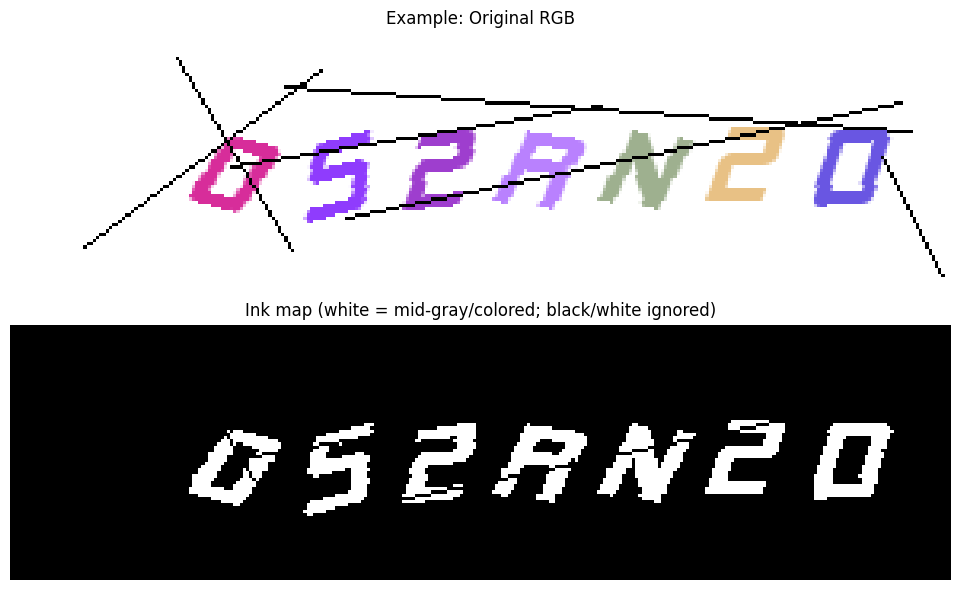

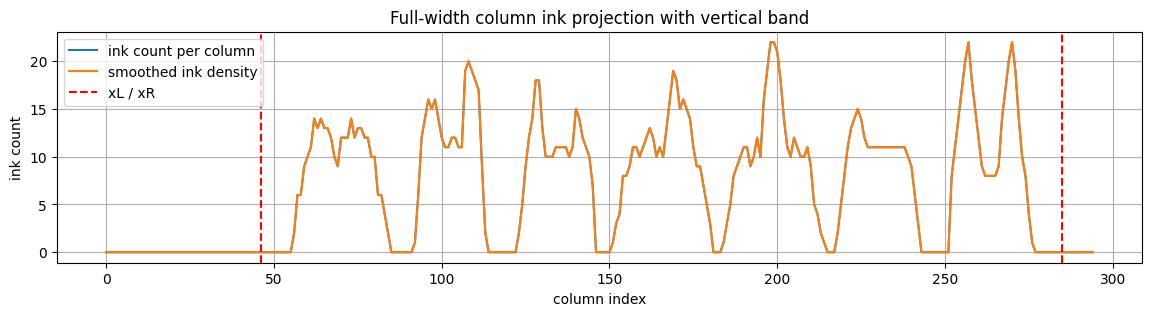

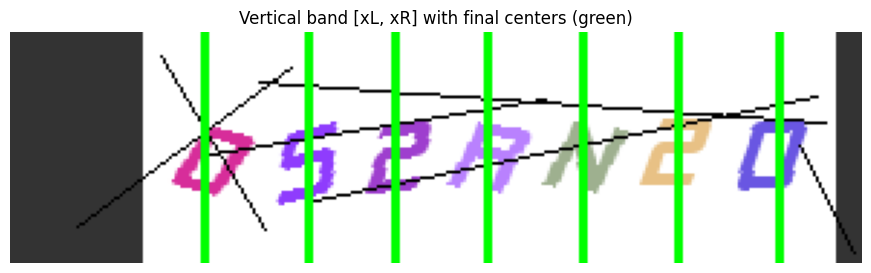

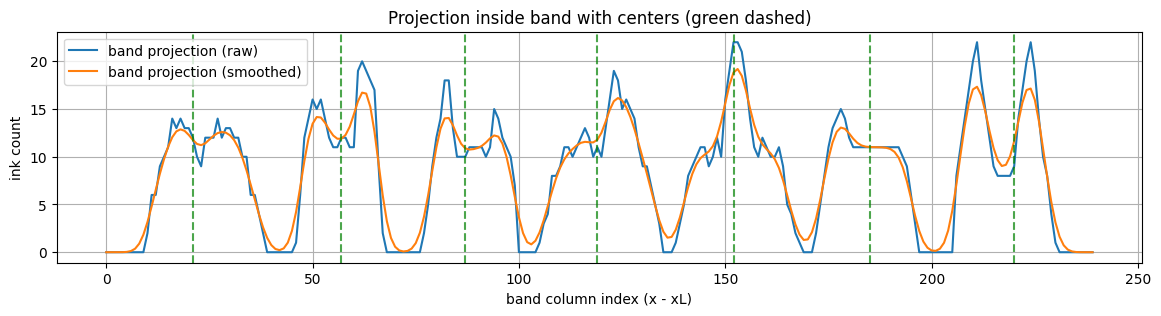

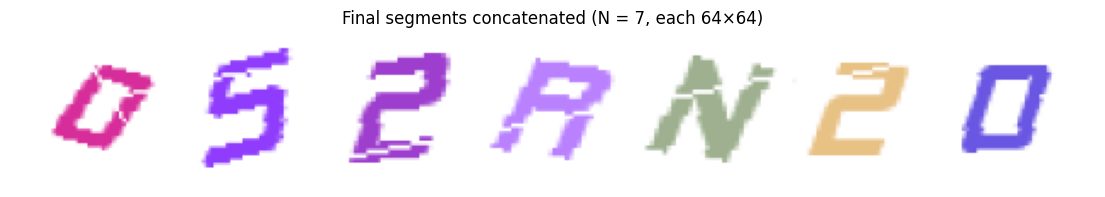

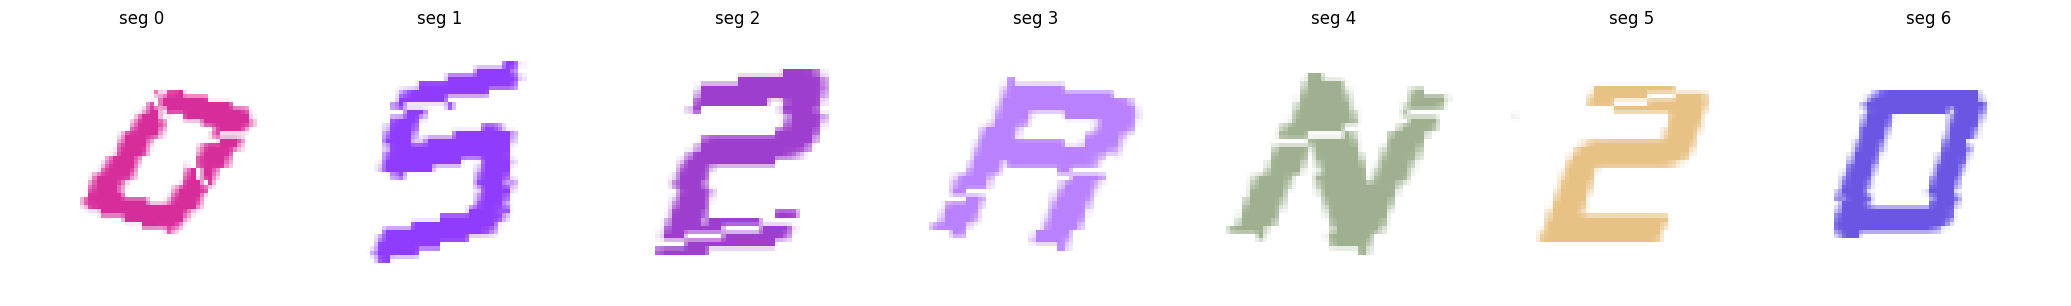

In [20]:
# Demo
img_path = "data\\test\\0s2rn2o-0.png"
# img_path = "data\\test\\1ctc5l-0.png"
# img_path = "data\\test\\0al4pl-0.png"
img_bgr  = cv2.imread(img_path)
img_rgb  = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# tiles, meta = segment_captcha_color_ink(
#     img_rgb, num_chars=8,
#     viz=True,
#     mask_kwargs=dict(black_gray_th=10,  # near-black 0..10
#                      white_gray_th=245, # near-white 245..255
#                      open_ksz=3, close_ksz=3),
#     proj_kwargs=dict(smooth_sigma=3, bin_th=5, min_run=5)
# )

img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

import os

fname = os.path.basename(img_path)   # e.g. "AL4PLZ-0.png"
text = fname.split("-")[0]           # "AL4PLZ"
num_chars = len(text)

tiles, dbg = segment_captcha_ink_inline(
    img_rgb, num_chars=num_chars,
    black_gray_th=10,
    white_gray_th=245,
    return_debug=True
)

plot_segmentation_ink_steps(img_rgb, tiles, dbg, title_prefix="Example: ")

In [21]:
from pathlib import Path
import cv2, numpy as np, random, os
from tqdm.auto import tqdm

# existing full-captcha folders
RAW_TRAIN_DIR = Path("data\\train")   # <-- your current train folder
RAW_TEST_DIR  = Path("data\\test")       # <-- your current test/val folder

# where to write new segmented character dataset
OUT_CHAR_ROOT = Path("seg_chars")  # new root; will create seg_chars/train, seg_chars/test

TARGET_SIZE   = 64   # char image size (what CNN expects)
RANDOM_SEED   = 42


c:\Users\cms07\miniconda3\envs\captcha-pt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
def parse_text_from_filename(path: Path) -> str:
    """
    'AL4PLZ-0.png' -> 'AL4PLZ'
    Adjust if your pattern is slightly different.
    """
    name = path.stem
    text = name.split("-")[0]
    return text

def ensure_dir(path: Path):
    path.mkdir(parents=True, exist_ok=True)


In [23]:
def segment_captcha_to_tiles(img_path: Path,
                             target_size: int = TARGET_SIZE,
                             debug: bool = False):
    text = parse_text_from_filename(img_path)
    num_chars = len(text)

    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        raise RuntimeError(f"Failed to read image: {img_path}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # If your segment_captcha_ink_inline returns ONLY tiles:
    if not debug:
        tiles = segment_captcha_ink_inline(
            img_rgb,
            num_chars=num_chars,
            target_size=target_size,
            return_debug=False
        )
        # NEW: convert RGB tiles → binary ink masks
        tiles = tiles_to_ink_masks(tiles)
    else:
        tiles, _dbg = segment_captcha_ink_inline(
            img_rgb,
            num_chars=num_chars,
            target_size=target_size,
            return_debug=True
        )
        # In debug mode we keep RGB tiles for visualisation

    if tiles is None or len(tiles) != num_chars:
        return None, text

    return tiles, text


In [24]:
def save_char_tiles(tiles, text, split_root: Path, base_name: str):
    """
    split_root: OUT_CHAR_ROOT/'train' or OUT_CHAR_ROOT/'test'
    Directory structure:
        seg_chars/train/<char>/*.png
        seg_chars/test/<char>/*.png

    tiles can be either:
      - 64×64×3 RGB, or
      - 64×64   binary (0/255) grayscale.
    """
    assert len(tiles) == len(text)

    for i, (tile, ch) in enumerate(zip(tiles, text)):
        char_dir = split_root / ch
        ensure_dir(char_dir)

        out_name = f"{base_name}_c{i}_{ch}.png"
        out_path = char_dir / out_name

        if tile.ndim == 3:   # RGB
            tile_to_save = cv2.cvtColor(tile, cv2.COLOR_RGB2BGR)
        else:                # 2D grayscale (our ink mask)
            tile_to_save = tile

        cv2.imwrite(str(out_path), tile_to_save)


In [25]:
def build_char_dataset_for_split(captcha_dir: Path, split_name: str):
    """
    captcha_dir: RAW_TRAIN_DIR or RAW_TEST_DIR
    split_name: 'train' or 'test'
    """
    paths = sorted(captcha_dir.glob("*.png"))
    print(f"[{split_name}] found {len(paths)} captcha images in {captcha_dir}")
    if not paths:
        return

    random.seed(RANDOM_SEED)
    # optional shuffle to mix image order
    random.shuffle(paths)

    split_root = OUT_CHAR_ROOT / split_name
    ensure_dir(split_root)

    failed = []

    for img_path in tqdm(paths, desc=f"Segmenting {split_name}"):
        base_name = img_path.stem  # e.g. 'AL4PLZ-0'
        try:
            tiles, text = segment_captcha_to_tiles(img_path, target_size=TARGET_SIZE)
        except Exception as e:
            print(f"[ERROR] {img_path}: {e}")
            failed.append((str(img_path), "exception"))
            continue

        if tiles is None:
            failed.append((str(img_path), "mismatch_len"))
            continue

        save_char_tiles(tiles, text, split_root, base_name)

    print(f"[{split_name}] done. Output at {split_root}, failed={len(failed)}")
    if failed:
        log_path = OUT_CHAR_ROOT / f"failed_{split_name}.txt"
        with open(log_path, "w") as f:
            for p, reason in failed:
                f.write(f"{reason}\t{p}\n")
        print(f"[{split_name}] failure log saved to {log_path}")


In [ ]:
# build_char_dataset_for_split(RAW_TRAIN_DIR, "train")
# build_char_dataset_for_split(RAW_TEST_DIR,  "test")

[train] found 8010 captcha images in data\train


Segmenting train:   5%|▌         | 425/8010 [00:05<01:43, 73.18it/s]


KeyboardInterrupt: 